In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

# Gene System

$$ G^{on} \xrightarrow{k_1} G^{on} + P  $$
$$ G^{on} + P \xrightarrow{k2} G^{off} $$
$$ G^{off} \xrightarrow{k_3} G^{on} + P $$
$$ P \xrightarrow{k_4} \emptyset $$

In [16]:
def rate1(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0

def rate2(X):
    rate = X[0]*X[1]
    if rate > 0:
        return rate
    else:
        return 0

def rate3(X):
    rate = (1-X[0])
    if rate > 0:
        return rate
    else:
        return 0
    
def rate4(X):
    rate = X[1]
    if rate > 0:
        return rate
    else:
        return 0    
    
def jac(X):
    ''' returns a matrix having as row the derivatives of the drift computed in X'''
    return np.array([[1, 0], [X[1], X[0]], [-1, 0], [0,1]])
    
    
# Model Parameters
drift = [rate1, rate2, rate3, rate4]
S_matrix = np.array([[0, 1], [-1, -1], [1, 1], [0, -1]])  # Stoichiometry matrix
c = np.array([1, 0.1, 0.1, 1])  # Reaction rates
X0 = np.array([1, 10])  # Initial state
T = 10  # Total time



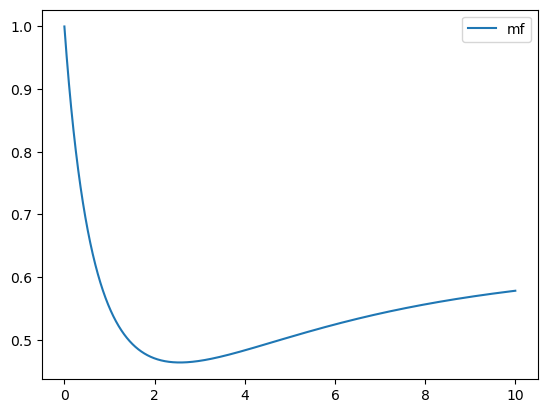

In [17]:
tmf = np.linspace(0,T, 5000)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

#plt.plot(t_ssa, x_ssa[:,0], label='SSA')
#plt.plot(t_tau, x_tau[:,0], label='Tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mf')
plt.legend()

In [37]:
def linear_noise(drift,jac,S,c,X0,t_axis):
    
    dt = t_axis[1] - t_axis[0]
    X = []
    X.append(X0)
    
    Sigma = []
    Sigma0 = np.zeros((len(X0), len(X0)))
    Sigma.append(Sigma0)
    
    def Dfunc(X):
        D = np.zeros((len(X0), len(X0)))
        for i in range(len(X0)):
            for j in range(i,len(X0)):
                D[i,j] = D[j,i] = sum([S[r,i]*S[r,j]*drift[r](X) for r in range(len(drift))])
        return D
    
    def Jfunc(X):
        return S.transpose().dot(jac(X))
    
    for j in range(len(t_axis)-1):
        a = c*np.array([rate(X[j]) for rate in drift])  # Propensity function
        X.append(X[j] + np.dot(a*dt,S))  # Update the state
        Sigma.append(Sigma[j] + dt*(Jfunc(X[j]).dot(Sigma[j]) + Sigma[j].dot(Jfunc(X[j]).transpose()) + Dfunc(X[j])))
                     
    return np.array(X), np.array(Sigma)
        
        
        

In [38]:
X, Sigma = linear_noise(drift,jac,S_matrix,c, X0, tmf)

In [35]:
np.array(Sigma)[:,0,0]

array([0.        , 0.020004  , 0.03897343, ..., 0.20330927, 0.2033089 ,
       0.20330853])

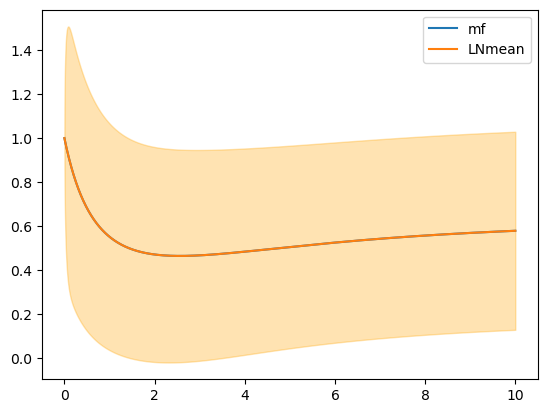

In [41]:
plt.plot(tmf, Xmf[:,0], label='mf')
plt.plot(tmf, X[:,0], label='LNmean')
plt.fill_between(tmf, X[:,0]-np.sqrt(Sigma[:,0,0]), X[:,0]+np.sqrt(Sigma[:,0,0]), alpha=0.3, color='orange')
plt.legend()